# Including Dependencies

In [1]:
!pip install efficientunet-pytorch
from efficientunet import *
from tqdm.notebook import tqdm
import os
import random
import argparse
import numpy as np
from torch.utils import data
from time import perf_counter
import time
import torch
import torch.nn as nn
from threading import Thread
import IPython

import json
import os
from collections import namedtuple


import torch.utils.data as data
from PIL import Image
import numpy as np

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import pickle
import zipfile
import torch.nn as nn
import torch.nn.functional as Fun
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
from torchvision import transforms
import requests

import cv2
import urllib
import IPython
from io import BytesIO
import matplotlib.pyplot as plt
import io
import pickle


  Created wheel for efficientunet-pytorch: filename=efficientunet_pytorch-0.0.6-py3-none-any.whl size=9457 sha256=93ca633d0db45838d6653c5508072114d1432bb49b7c0a741b0d76ca9a136540
  Stored in directory: /root/.cache/pip/wheels/84/c5/98/c9bb8ce1c9427466455cbbc3a8117485ca7eab38a03558457c
Successfully built efficientunet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Utility Functions

In [2]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=0, size_average=True, ignore_index=255):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.size_average = size_average

    def forward(self, inputs, targets):
        ce_loss = Fun.cross_entropy(
            inputs, targets, reduction='none', ignore_index=self.ignore_index)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        if self.size_average:
            return focal_loss.mean()
        else:
            return focal_loss.sum()


class _StreamMetrics(object):
    def __init__(self):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def update(self, gt, pred):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def get_results(self):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def to_str(self, metrics):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def reset(self):
        """ Overridden by subclasses """
        raise NotImplementedError()      

class StreamSegMetrics(_StreamMetrics):
    """
    Stream Metrics for Semantic Segmentation Task
    """
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def update(self, label_trues, label_preds):
        #boolarr=label_trues==255
        #label_preds[boolarr]=255
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist( lt.flatten(), lp.flatten() )
    
    @staticmethod
    def to_str(results):
        string = "\n"
        for k, v in results.items():
            if k!="Class IoU":
                string += "%s: %f\n"%(k, v)
        
        #string+='Class IoU:\n'
        #for k, v in results['Class IoU'].items():
        #    string += "\tclass %d: %f\n"%(k, v)
        return string

    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.n_classes)
        hist = np.bincount(
            self.n_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.n_classes ** 2,
        ).reshape(self.n_classes, self.n_classes)
        return hist

    def get_results(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))
#         cls_ac = dict(zip(range(self.n_classes),np.diag(hist)/(hist.sum(axis=1))))

        return {
                "Overall Acc": acc,
                "Mean Acc": acc_cls,
                "FreqW Acc": fwavacc,
                "Mean IoU": mean_iu,
                #"Class Acc": cls_ac,
                "Class IoU": cls_iu,
            }
        
    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

class AverageMeter(object):
    """Computes average values"""
    def __init__(self):
        self.book = dict()

    def reset_all(self):
        self.book.clear()
    
    def reset(self, id):
        item = self.book.get(id, None)
        if item is not None:
            item[0] = 0
            item[1] = 0

    def update(self, id, val):
        record = self.book.get(id, None)
        if record is None:
            self.book[id] = [val, 1]
        else:
            record[0]+=val
            record[1]+=1

    def get_results(self, id):
        record = self.book.get(id, None)
        assert record is not None
        return record[0] / record[1]

_pil_interpolation_to_str = {
    Image.NEAREST: 'PIL.Image.NEAREST',
    Image.BILINEAR: 'PIL.Image.BILINEAR',
    Image.BICUBIC: 'PIL.Image.BICUBIC',
    Image.LANCZOS: 'PIL.Image.LANCZOS',
    Image.HAMMING: 'PIL.Image.HAMMING',
    Image.BOX: 'PIL.Image.BOX',
}
class ExtResize(object):
    """Resize the input PIL Image to the given size.
    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        #assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be scaled.
        Returns:
            PIL Image: Rescaled image.
        """
        return F.resize(img, self.size, self.interpolation), F.resize(lbl, self.size, Image.NEAREST)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        return self.__class__.__name__ + '(size={0}, interpolation={1})'.format(self.size, interpolate_str) 

In [3]:
from torchvision.transforms.functional import normalize
import torch.nn as nn
import numpy as np
import os 

def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)

    _mean = -mean/std
    _std = 1/std
    return normalize(tensor, _mean, _std)

class Denormalize(object):
    def __init__(self, mean, std):
        mean = np.array(mean)
        std = np.array(std)
        self._mean = -mean/std
        self._std = 1/std

    def __call__(self, tensor):
        if isinstance(tensor, np.ndarray):
            return (tensor - self._mean.reshape(-1,1,1)) / self._std.reshape(-1,1,1)
        return normalize(tensor, self._mean, self._std)

def set_bn_momentum(model, momentum=0.1):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.momentum = momentum

def fix_bn(model):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

# Loading Utils files Model

In [4]:
os.chdir("/kaggle/input/script/")
!python utils.py

from utils import *

!ls
os.chdir("..")
os.chdir('../working')


deeplab.py  fchardnet.py  mobile_net.py  resnet.py  utils.py


# DataLoader

In [5]:
import json
import os
from collections import namedtuple

import torch
import torch.utils.data as data
from PIL import Image
import numpy as np


class CustomData(data.Dataset):

    colorMap={
        "backgroud": (225,229 , 204),
        'wall':(152, 152, 79),
        'building':(70, 70, 70),
        'sky':(70, 130, 180),
        'sidewalk':(244, 35, 232),
        'field/grass':(152, 251, 152),
        'vegitation':(107, 142, 35),
        'person': (220, 20, 60),
        'mountain':(139, 218, 51),
        'stairs':(202, 251, 254),
        'bench':(108, 246, 107),
        'pole':(153, 153, 153),
        'car':(41, 34, 177),
        'bike':(111, 34, 177),
        'animal':(211, 205, 33),
        'ground':(147, 147, 136),
        'fence':(241, 170, 17),
        'water':(29, 231, 229),
        'road':(35, 18, 16),
        'sign_board':(113, 97, 41),
        'floor':(73, 23, 77),
        'traffic_light':(225, 175, 57),
        'ceeling':(51, 0, 0),
        'unlabelled':(0,0,0),
        
    }
     
    CustomDataSet = namedtuple('CustomDataSet', ['name', 'id', 'train_id', 'category', 'category_id',
                                                     'has_instances', 'ignore', 'color'])
    classes = [
            CustomDataSet('backgroud',       0, 0, 'obstacle', 0, False, True, colorMap['backgroud']),
            CustomDataSet('wall',            1, 1, 'solid', 0, False, True, colorMap['wall']),
            CustomDataSet('building',        2, 2, 'solid', 0, False, True, colorMap['building']),
            CustomDataSet('sky',             3, 3, 'backgroud', 0, False, True, colorMap['sky']),
            CustomDataSet('sidewalk',        4, 4, 'nature', 0, False, True, colorMap['sidewalk']),
            CustomDataSet('field/grass',     5, 5, 'nature', 0, False, True, colorMap['field/grass']),
            CustomDataSet('vegitation',      6, 6, 'nature', 0, False, True, colorMap['vegitation']),
            CustomDataSet('person',          7, 7, 'human', 0, False, True, colorMap['person']),
            CustomDataSet('mountain',        8, 8, 'nature', 0, False, True, colorMap['mountain']),
            CustomDataSet('stairs',          9, 255, 'solid', 0, False, False, colorMap['stairs']),
            CustomDataSet('bench',           10, 0, 'obstacle', 0, False, False, colorMap['bench']),
            CustomDataSet('pole',            11, 0, 'obstacle', 0, False, False, colorMap['pole']),
            CustomDataSet('car',             12, 9, 'vahicle', 0, False, True, colorMap['car']),
            CustomDataSet('bike',            13, 10, 'vahicle', 0, False, True, colorMap['bike']),
            CustomDataSet('animal',          14, 11, 'animal', 0, False, True, colorMap['animal']),
            CustomDataSet('ground',          15, 12, 'land', 0, False, True, colorMap['ground']),
            CustomDataSet('fence',           16, 13, 'solid', 0, False, True, colorMap['fence']),
            CustomDataSet('water',           17, 14, 'land', 0, False, True, colorMap['water']),
            CustomDataSet('road',            18, 15, 'land', 0, False, True, colorMap['road']),
            CustomDataSet('sign_board',      19, 0, 'obstacle', 0, False, False, colorMap['sign_board']),
            CustomDataSet('floor',           20, 4, 'land', 0, False, False, colorMap['floor']),
            CustomDataSet('traffic_light',   21, 0,'obstacle', 0, False, False, colorMap['traffic_light']),
            CustomDataSet('ceeling',         22, 16, 'ceeling', 0, False, True, colorMap['ceeling']),
            CustomDataSet('unlabelled',      23, 255, 'void', 0, False, False, colorMap['unlabelled']),
            
    ]
    
    train_id_to_color = [c.color for c in classes if (c.ignore)]
    train_id_to_color.append([0, 0, 0])
    train_id_to_color = np.array(train_id_to_color)

    train_id_to_label= [c.name for c in classes if (c.ignore)]
    train_id_to_label.append("unlabeled")
    train_id_to_label = np.array(train_id_to_label)
    
    
    id_to_train_id = np.array([c.train_id for c in classes])
    
    def __init__(self, root_image, root_target, split='train', mode='fine', target_type='semantic', transform=None):        
        
        self.root_image = [os.path.expanduser(i) for i in root_image ]
        self.root_target = [os.path.expanduser(i) for i in root_target]
        
        self.images = []
        self.targets = []
        self.transform = transform
        self.split = split
        
        for i in range(len(self.root_image)):
            self.root_image[i]=os.path.join(self.root_image[i],split)
            self.root_target[i]=os.path.join(self.root_target[i],split)
            print(self.root_image[i])
            print(self.root_target[i])

            lst=os.listdir(self.root_target[i])
            
            for img in lst:
                if img[0]=="C":
                    self.images.append(os.path.join(root_image[i],img[:-4]+'.jpg'))
                else:
                    self.images.append(os.path.join(self.root_image[i],img[:-4]+'.jpg'))
                self.targets.append(os.path.join(self.root_target[i],img))
        print(len(self.images))
        print(len(self.targets))


    @classmethod
    def encode_target(cls, target):
        return cls.id_to_train_id[np.array(target)]

    @classmethod
    def decode_target(cls, target):
        target[target == 255] = 0
        #target = target.astype('uint8') + 1
        return cls.train_id_to_color[target]

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.targets[index])
        
       
        if self.transform:
            image, target = self.transform(image, target)
        target = self.encode_target(target)
        #print(image.shape)
        #print(target.shape)
        
        return image, target

    def __len__(self):
        return len(self.images)

# Training Setup

In [6]:
from matplotlib import gridspec

def create_label_colormap():
    colormap = CustomData.train_id_to_color
    return colormap


def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image,seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image =  CustomData.decode_target(seg_map.cpu()).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    print("Uniques Labels Found",unique_labels)
    ax = plt.subplot(grid_spec[3])
    
    
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = CustomData.train_id_to_label

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [9]:
##Get Datatset
def get_dataset(imageFolders,targetFolders,batchSize,valBatchSize):
    """ Dataset And Augmentation
    """
    train_transform = ExtCompose([
        ExtResize((256,256)),
        ExtColorJitter( brightness=0.5, contrast=0.5, saturation=0.5 ),
        ExtRandomHorizontalFlip(),
        ExtToTensor(),
        ExtNormalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    ])
    val_transform = ExtCompose([
        ExtResize((256,256)),
        ExtToTensor(),
        ExtNormalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    ])

    train_dst = CustomData(root_image=imageFolders,root_target=targetFolders,
                           split='training', transform=train_transform)
    val_dst = CustomData(root_image=imageFolders,root_target=targetFolders,
                         split='validation', transform=val_transform)
    train_loader = data.DataLoader(train_dst, batch_size=batchSize, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = data.DataLoader(val_dst, batch_size=valBatchSize, shuffle=True, num_workers=4)
    return train_loader, val_loader


##Validation Fucntion
def validate1(model,loader,metrics,device):
    
    metrics.reset()
    #validation_loss = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(images)
            preds = outputs.detach().max(dim=1)[1].cpu().numpy()
            targets=labels.cpu().numpy()            
            metrics.update(targets, preds)

    return metrics.get_results()

def GetPretrainedModel(device,model,num_classes=17, savedPath="/", pretrained=False,  continue_training=False, optimizer=None, scheduler=None):
    cur_epoch=0
    best_score=0
    if pretrained:
        ckpt=saved_path+"last_model.pth"
        checkpoint = torch.load(ckpt, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint["model_state"])

        model.to(device)
        with open(saved_path+"Loss.txt","rb") as File:
            Loss = pickle.load(File)
        with open(saved_path+"Score.txt","rb") as File:
            Score = pickle.load(File)
        if continue_training:
            optimizer.load_state_dict(checkpoint["optimizer_state"])
            scheduler.load_state_dict(checkpoint["scheduler_state"])
            cur_epoch = checkpoint["epoch"]
            best_score = checkpoint['best_score']
            print("Training state restored from %s" % saved_path)
        print("Model restored from %s" % saved_path)
        del checkpoint  # free memory
    else:
        model.to(device)

    if continue_training:
        return cur_epoch, best_score, optimizer, scheduler, model
    return cur_epoch, best_score, model

In [10]:
def TrainModel(imageFolders,targetFolders,learningRate=0.00001,weightDecay=0.0001,learningRatePolicy='poly', noOfEpochs=27,
              stepSize=10000, savedPath="/",pretrained=False, batchSize=16,valBatchSize=16, lossFunction="focal", useCuda=True):
    
    continue_training=True
    num_classes=17
    
    train_loader, val_loader=get_dataset(imageFolders,targetFolders,batchSize,valBatchSize)
    device = torch.device('cuda' if (torch.cuda.is_available() and useCuda==True) else 'cpu')
    
    model = get_efficientunet_b0(out_channels=num_classes, concat_input=True, pretrained=True)
    
    
    #Optimizer, Metric, scheduler and Loss Function
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, momentum=0.9, weight_decay=weightDecay)
    metrics = StreamSegMetrics(num_classes)
    
    if lossFunction=="focal":
        criterion = FocalLoss(ignore_index=255, size_average=True)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stepSize, gamma=0.1)
    
    ##pretraining Code
    cur_epoch=0
    best_score=0
    Loss=[]
    Score=[]
    
    cur_epoch, best_score,optimizer,scheduler, model= GetPretrainedModel(model=model, device=device,num_classes=num_classes, savedPath=savedPath, pretrained=pretrained,  continue_training=continue_training, optimizer=optimizer, scheduler=scheduler)
    
    ##Training Loop
    print("Accuracy Of Model at epoch "+ str(cur_epoch)+ " is: "+ str(best_score))
    
    interval_loss = 0
    epochs=cur_epoch+noOfEpochs
    max_score=10000000000
    model_curve=[]

    best_score = 0.0
    cur_itrs=0
    start = perf_counter()
    for epoch in tqdm(range(cur_epoch+1,epochs), desc="Epochs"):
        model.train()
        running_loss = []
        for step, (images, labels) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            cur_itrs += 1
            #print(images.shape)
            #print(labels.shape)

            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #end = perf_counter()

            running_loss.append(loss.item())
            interval_loss += loss.item()

        model.eval()
        val_score = validate1(model=model, loader=val_loader, metrics=metrics,device=device)
        print("Training Loss",np.mean(running_loss),"Validation Loss")
        print(metrics.to_str(val_score))

        #if val_score['Mean IoU'] > best_score:  # save best model
        best_score = val_score['Mean IoU']
        mkdir("./Files")
        
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "best_score": best_score,
        }, './Files/last_model.pth')

        Loss.append(np.mean(running_loss))
        Score.append(val_score)

        with open("./Files/Loss.txt","wb") as File:
            pickle.dump(Loss,File)
        with open("./Files/Score.txt","wb") as File:
            pickle.dump(Score,File)

        scheduler.step()
        print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))
    end = perf_counter()
    print("Time",end-start)
    
    
    

# Training Function Call

To train a function, you must give the path of the folders which contains both training and validation folder in it.

* imageFolders are the path of Images
* targetFolders are the path of Groundtruth
* noOfEpochs is the epochs
* if pretrained=True then you must give savedPath=path for a pretrained weights
* if GPU is available,use useCuda=True
* Use batchSize for training batch size
* Use valBatchSize for validation batch size
* loss function could be 'focal' or 'entropy'
* 255 is always the ignore index, which means it will not calculate the loss of 255 label
* Your ground truth must have labels 0 to 16, and it can have 255 to ignore it

In [11]:
imageFolder= [
                 # '../input/adek20-screen-parsing/ADEChallengeData2016/images',
                 # '../input/adek20-screen-parsing/ADEChallengeData2016/images',
                 # '../input/coco-dataset/Coco Stuff Dataset/images',
                  '../input/custom-sidewalk/custom_sidewalk_updated/customdataset',
                 ]


targetFolder=[
        #'../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Updated/adk',
         #         '../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Updated/adk_floor_filter',
          #        '../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Updated/coco',
                  '../input/custom-sidewalk/custom_sidewalk_updated/customannotations',
            ]
saved_path="../input/unetb0results/Files/"
TrainModel(imageFolders=imageFolder, targetFolders=targetFolder, savedPath=saved_path, pretrained=True)

../input/custom-sidewalk/custom_sidewalk_updated/customdataset/training
../input/custom-sidewalk/custom_sidewalk_updated/customannotations/training
68
68
../input/custom-sidewalk/custom_sidewalk_updated/customdataset/validation
../input/custom-sidewalk/custom_sidewalk_updated/customannotations/validation
1
1


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Training state restored from ../input/unetb0results/Files/
Model restored from ../input/unetb0results/Files/
Accuracy Of Model at epoch 100 is: 0.12355298958544907


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide


Training Loss 0.7888911366462708 Validation Loss

Overall Acc: 0.000000
Mean Acc: 0.000000
FreqW Acc: 0.000000
Mean IoU: 0.000000

Epoch: 102/127 - Loss: 0.7889


Training Loss 0.8192886590957642 Validation Loss

Overall Acc: 0.000000
Mean Acc: 0.000000
FreqW Acc: 0.000000
Mean IoU: 0.000000

Epoch: 103/127 - Loss: 0.8193


Training Loss 0.7159873008728027 Validation Loss

Overall Acc: 0.000000
Mean Acc: 0.000000
FreqW Acc: 0.000000
Mean IoU: 0.000000

Epoch: 104/127 - Loss: 0.7160


Training Loss 0.8013233542442322 Validation Loss

Overall Acc: 0.000000
Mean Acc: 0.000000
FreqW Acc: 0.000000
Mean IoU: 0.000000

Epoch: 105/127 - Loss: 0.8013


Training Loss 0.7694056630134583 Validation Loss

Overall Acc: 0.000000
Mean Acc: 0.000000
FreqW Acc: 0.000000
Mean IoU: 0.000000




KeyboardInterrupt: 

# Prediction Function Setup

In [12]:
def PredictImage(input_image, useCuda=True,num_classes=17,pretrained=False, saved_path="/" ):
    
    device = torch.device('cuda' if (torch.cuda.is_available() and useCuda==True) else 'cpu')
    model = get_efficientunet_b0(out_channels=num_classes, concat_input=True, pretrained=True)
    cur_epoch, best_score, model= GetPretrainedModel(model=model, device=device,num_classes=num_classes, savedPath=saved_path, pretrained=pretrained,  continue_training=False, optimizer=None, scheduler=None)
    print("Accuracy Of Model at epoch "+ str(cur_epoch)+ " is: "+ str(best_score))

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor= preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    
    if torch.cuda.is_available() and useCuda==True:
        input_batch = input_batch.to('cuda')
    model.eval()
    with torch.no_grad():
        start = perf_counter()
        output = model(input_batch)[0]
        end = perf_counter()
        print(end-start)

    output_predictions = output.argmax(0)
    pred = CustomData.decode_target(output_predictions.cpu()).astype(np.uint8)
    vis_segmentation(input_image, output_predictions.cpu())

# Prediction Function Call

* input_image: path of the image to predict
* pretrained: True if model has pretrained weights
* saved_path : path of pretrained weigths
* useCuda: True if GPU is available
* num_classes: no of classes your model has

Model restored from ../input/unetb0results/Files/
Accuracy Of Model at epoch 0 is: 0
0.017072347999999238
Uniques Labels Found [ 1  2  3  5  6  7 12 15]


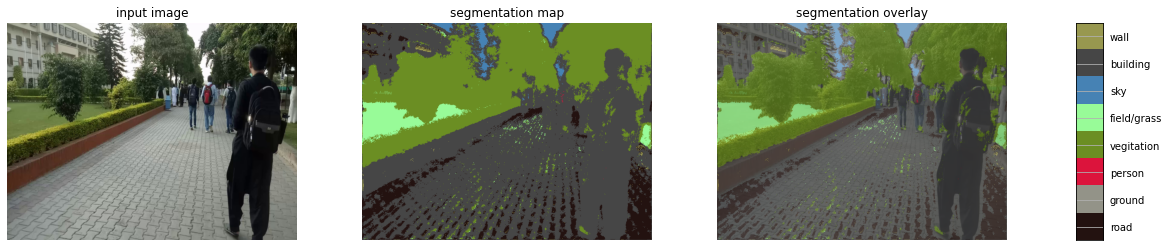

In [13]:
saved_path="../input/unetb0results/Files/"
preprocess_input= transforms.Compose([
    transforms.Resize((480,640)),
])
input_image = Image.open("../input/my-dataset/images/12.jpg")
input_image=preprocess_input(input_image)

PredictImage(input_image, pretrained=True,saved_path=saved_path)

# Video Function Call

* video_path: path of the video to predict
* pretrained: True if model has pretrained weights
* saved_path : path of pretrained weigths
* useCuda: True if GPU is available
* num_classes: no of classes your model has
* num_frames: frames process from the entire video
* output_path: path of resultant output (.mp4)

In [14]:
def PredictVideo(video_path,useCuda=True,num_classes=17,pretrained=False, num_frames = 20000 ,saved_path="result",output_path="results"):
    
    device = torch.device('cuda' if (torch.cuda.is_available() and useCuda==True) else 'cpu')
    model = get_efficientunet_b0(out_channels=num_classes, concat_input=True, pretrained=True)
    cur_epoch, best_score, model= GetPretrainedModel(model=model, device=device,num_classes=num_classes, savedPath=saved_path, pretrained=pretrained,  continue_training=False, optimizer=None, scheduler=None)
    print("Accuracy Of Model at epoch "+ str(cur_epoch)+ " is: "+ str(best_score))
    
    preprocess_input= transforms.Compose([
    transforms.Resize((480,640)),])
    
    preprocess = transforms.Compose([
        transforms.Resize((480,640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
    np_buff=[]
    def run_model(input_image):
        input_tensor= preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0) 
        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')
        model.eval()
        with torch.no_grad():
            output = model(input_batch)[0]
        output_predictions = output.argmax(0)
        return output_predictions
    def vis_segmentation_stream(image, seg_map, index):
        seg_image = CustomData.decode_target(seg_map.cpu()).astype(np.uint8)
        seg_image=Image.fromarray(seg_image.astype('uint8'), 'RGB')

        background = image.convert("RGBA")
        overlay = seg_image.convert("RGBA")

        new_img = Image.blend(background, overlay, 0.7)
        img=np.array(new_img)
        np_buff.append(img)
    def run_visualization_video(frame, index):
        original_im = Image.fromarray(frame[..., ::-1])
        original_im=preprocess_input(original_im)
        seg_map = run_model(original_im)
        vis_segmentation_stream(original_im, seg_map, index)
        
    def convert_to_video():
        print("Video path", output_path)
        print("Output Length", len(np_buff))
        video=cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'DIVX'), 15,(np_buff[0].shape[1],np_buff[0].shape[0]))
        for i in np_buff:
            i=i[:,:,:-1]
            video.write(i[:,:,::-1])
        video.release()
        print("Your result is saved as ",output_path)

    if not os.path.isfile(video_path): 
        print('downloading the sample video...')
        video_path = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4')[0]
        print('running deeplab on the sample video...')
        
    print("Opening video ", video_path)
    video = cv2.VideoCapture(video_path)
    
    try:
        start = perf_counter()
        for i in range(num_frames):
            _, frame = video.read()
            if not _: break
            if i%15==0:
                run_visualization_video(frame, i)
        end = perf_counter()
        sec=end-start
        print(sec, "seconds to process video")
        convert_to_video()
        
       
    except KeyboardInterrupt:
        plt.close()
        print("Stream stopped.")
        
  


In [15]:
output_path="result1.mp4"
video_path="../input/video-test/xyz.mp4"
saved_path="../input/unetb0results/Files/"
PredictVideo(saved_path=saved_path,pretrained=True,video_path=video_path,num_frames=500,output_path=output_path)

FileNotFoundError: [Errno 2] No such file or directory: '../input/fdnet-results-16-classes/Files/last_model.pth'